In [141]:
import torch
import torch.nn as nn

In [142]:
class ImageNN(torch.nn.Module):
    def __init__(self):
        super(ImageNN, self).__init__()
        self.neural_network_graph = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 500), # 28x28 = 784 pixels (Input layer)
            nn.ReLU(), # ReLU activation function
            nn.Linear(500, 350),
            nn.Dropout(0.5),  # Dropout with a dropout rate of 0.5 - Bey2alel el overfitting
            nn.LayerNorm(350),
            nn.ReLU(),
            nn.Linear(350, 200),
            nn.ReLU(),
            nn.Linear(200, 10), # 10 classes (Output layer)
        )

    def forward(self, x):
        return self.neural_network_graph(x)

In [143]:
import matplotlib.pyplot as plt

def plot_metrics(train_losses_, val_losses_, train_accuracies_, val_accuracies_):
    epochs_range = range(1, len(train_losses_) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses_, label='Training Loss')
    plt.plot(epochs_range, val_losses_, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies_, label='Training Accuracy')
    plt.plot(epochs_range, val_accuracies_, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [144]:
def train(dataloader, mod, loss_fn, optimizer):
    mod.train() # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad() # Zero the gradients to avoid accumulation
        outputs = mod(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    # Calculate average loss and accuracy for the epoch
    average_loss = running_loss / len(dataloader)
    train_acc = correct / total

    return average_loss, train_acc

def evaluate(dataloader, mod, loss_fn):
    mod.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for val_inputs, val_labels in dataloader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

            val_outputs = mod(val_inputs)
            validation_loss = loss_fn(val_outputs, val_labels)
            val_running_loss += validation_loss.item()

            _, predicted = torch.max(val_outputs, 1)
            correct += (predicted == val_labels).sum().item()
            total += val_labels.size(0)

    validation_loss = val_running_loss / len(dataloader)
    validation_accuracy = correct / total

    return validation_loss, validation_accuracy

## 1) Data Preparation

In [145]:
from sklearn.model_selection import train_test_split
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # Subtract 0.5 and divide by 0.5 -> map to [-1, 1]
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

train_dataset, val_dataset = train_test_split(
    train_dataset,
    test_size=0.2,
)

batch_size = 32
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
# test_dataloader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

## 2) Model

In [146]:
model = ImageNN()
learning_rate = 0.01
cross_entropy_loss = torch.nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters(), lr=learning_rate)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

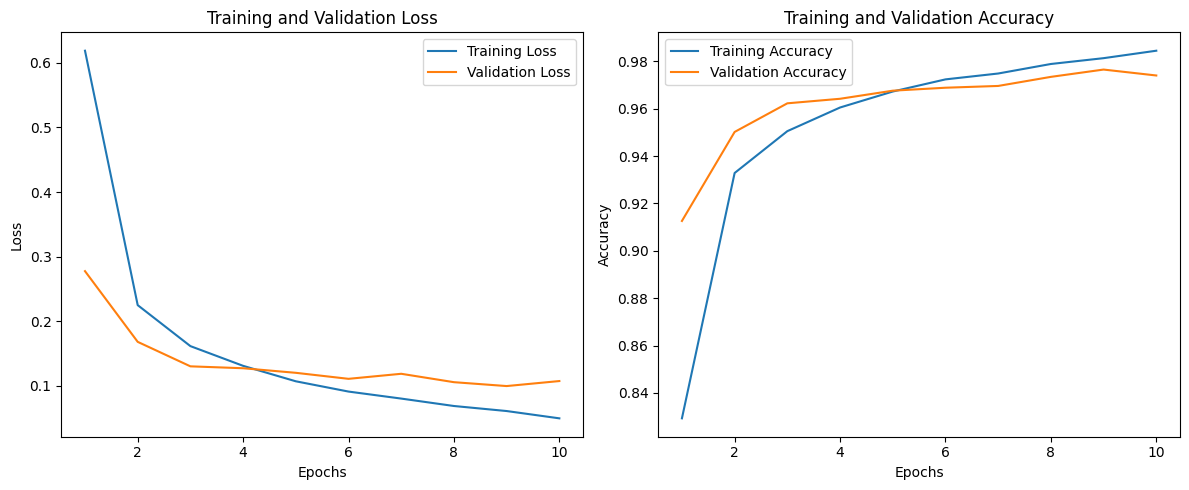

In [147]:
epochs = 10
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
for t in range(epochs):
    train_loss, train_accuracy = train(train_dataloader, model, cross_entropy_loss, opt)
    val_loss, val_accuracy = evaluate(val_dataloader, model, cross_entropy_loss)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

In [148]:
print("Final Training Loss: {:.5f}\nFinal Training Accuracy: {:.2f}%".format(train_losses[-1], train_accuracies[-1]*100))

Final Training Loss: 0.04993
Final Training Accuracy: 98.45%


## 3) Analysis

In [149]:
learning_rates = [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
batch_sizes = [32, 64, 128, 256, 512]

results = []

learning_rate_acc = {}
for lr in learning_rates:
    val_loss_avg = 0
    val_acc_avg = 0
    for batch_size in batch_sizes:
        model = ImageNN()
        opt = torch.optim.SGD(model.parameters(), lr=lr)
        cross_entropy_loss = nn.CrossEntropyLoss()
        
        train(train_dataloader, model, cross_entropy_loss, opt)
        val_loss, val_accuracy = evaluate(val_dataloader, model, cross_entropy_loss)

        results.append({
            'learning_rate': lr,
            'batch_size': batch_size,
            'validation_loss': val_loss,
            'validation_accuracy': val_accuracy
        })
        val_acc_avg += val_accuracy

    learning_rate_acc[lr] = val_acc_avg / len(batch_sizes)

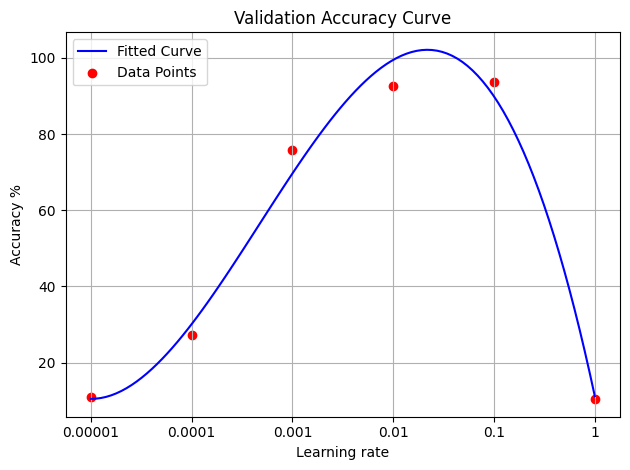

Epoch 1:
Learning Rate: 1.00000, Batch Size: 32
Validation Loss: 2.30678
Validation Accuracy: 10.22%
Epoch 2:
Learning Rate: 1.00000, Batch Size: 64
Validation Loss: 2.30916
Validation Accuracy: 11.26%
Epoch 3:
Learning Rate: 1.00000, Batch Size: 128
Validation Loss: 2.30938
Validation Accuracy: 9.88%
Epoch 4:
Learning Rate: 1.00000, Batch Size: 256
Validation Loss: 2.30502
Validation Accuracy: 9.73%
Epoch 5:
Learning Rate: 1.00000, Batch Size: 512
Validation Loss: 2.30624
Validation Accuracy: 10.90%
Epoch 6:
Learning Rate: 0.10000, Batch Size: 32
Validation Loss: 0.21850
Validation Accuracy: 94.42%
Epoch 7:
Learning Rate: 0.10000, Batch Size: 64
Validation Loss: 0.24113
Validation Accuracy: 93.80%
Epoch 8:
Learning Rate: 0.10000, Batch Size: 128
Validation Loss: 0.26376
Validation Accuracy: 93.36%
Epoch 9:
Learning Rate: 0.10000, Batch Size: 256
Validation Loss: 0.27927
Validation Accuracy: 93.35%
Epoch 10:
Learning Rate: 0.10000, Batch Size: 512
Validation Loss: 0.25503
Validation Ac

In [150]:
# Draw bell curve using matplotlib
import numpy as np

def plot_bell_curve(acc):
    y_acc_values = list(acc.values())
    x_acc_values = list(acc.keys())
    x_acc_values_labels = []
    

    for j in range(len(y_acc_values)):
        y_acc_values[j] = y_acc_values[j] * 100
    
    for j in range(len(x_acc_values)):
        x_acc_values_labels.append("{:.{}f}".format(x_acc_values[j], 5).rstrip('0').rstrip('.'))
        x_acc_values[j] = np.log10(x_acc_values[j])
    
    degree = 3  # Change the degree of the polynomial as needed
    coefficients = np.polyfit(x_acc_values, y_acc_values, degree)
    poly = np.poly1d(coefficients)
    x_curve = np.linspace(min(x_acc_values), max(x_acc_values), 100)
    y_curve = poly(x_curve)
    
    plt.xticks(x_acc_values, x_acc_values_labels)
    
    plt.plot(x_curve, y_curve, label='Fitted Curve', color='blue')
    plt.scatter(x_acc_values, y_acc_values, color='red', label='Data Points')
    plt.title('Validation Accuracy Curve')
    plt.xlabel('Learning rate')
    plt.ylabel('Accuracy %')
    plt.legend()
    plt.grid(True)
    
    
    plt.tight_layout()
    plt.show()

plot_bell_curve(learning_rate_acc)

# Print or analyze the results
for i in range(len(results)):
    result = results[i]
    print(f"Epoch {i+1}:")
    print("Learning Rate: {:.5f}, Batch Size: {}".format(result['learning_rate'], result['batch_size']))
    print("Validation Loss: {:.5f}\nValidation Accuracy: {:.2f}%".format(result['validation_loss'], result['validation_accuracy']*100))
    print("=" * 50)

We are using PyTorch for classifying MNIST handwritten digits.

### Model Architecture:
- Input Layer: Flatten layer for inputting the 28x28 pixel images.
- Hidden Layers: Three fully connected layers with ReLU activations, gradually decreasing in width from 500 to 350 to 200 neurons.
- Output Layer: Final fully connected layer with 10 neurons (corresponding to 10 classes of digits).

### Training and Evaluation Functions:
- `train`: Trains the neural network model using the training dataset and returns the average loss and training accuracy per epoch.
- `evaluate`: Evaluates the model's performance on the validation dataset and returns the average loss and validation accuracy per epoch.

### Dataset Preparation:
The MNIST dataset is loaded, split into training and validation sets using a 80:20 split, and transformed using normalization to map pixel values to the range [-1, 1].

### Insights:
Using the default learning rate of 0.01, the model achieves a validation accuracy of 98.87% after 10 epochs.
The accuracy increases with each epoch and the loss decreases with each epoch, indicating that the model is learning and improving.

### Learning rate tuning:
We experiment with different values of the learning rate and batch size to find the best combination of hyperparameters.
When variating between the learning rates we find that there is a sweet spot between 0.1 and 0.01 where the model achieves the highest validation accuracy.
